### Data visualization

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from pycwt import wavelet
import pandas as pd
# =========================
# Internal helpers (unchanged)
# =========================
def _prep_unique_sorted(t, s):
    m = np.isfinite(t) & np.isfinite(s)
    t = np.asarray(t[m], float); s = np.asarray(s[m], float)
    if t.size < 2: raise ValueError("Not enough points after filtering.")
    order = np.argsort(t); t = t[order]; s = s[order]
    dt = np.diff(t); keep = np.hstack(([True], dt != 0))
    return t[keep], s[keep]

def centers_to_edges(c):
    c = np.asarray(c, float).ravel()
    if c.size < 2: return np.array([c[0]-0.5, c[0]+0.5], float)
    dc = np.diff(c); e = np.empty(c.size + 1, float)
    e[1:-1] = c[:-1] + dc/2; e[0] = c[0] - dc[0]/2; e[-1] = c[-1] + dc[-1]/2
    return e

def cwt_wrap(sig, dt, dj, s0, J, wv='morlet'):
    out = wavelet.cwt(sig, dt, dj=dj, s0=s0, J=J, wavelet=wv)
    W, scales = out[0], out[1]
    coi = out[3] if len(out) >= 4 else None
    return W, np.asarray(scales, float), (None if coi is None else np.asarray(coi, float))

def _smooth_time_scale(A, scales, dt, dj):
    A = np.asarray(A); Ns, Nt = A.shape
    out = np.empty((Ns, Nt), dtype=np.complex128)
    scales = np.asarray(scales, float).ravel()
    for i, s in enumerate(scales):
        sigma_t = max(1e-9, np.sqrt(2.0) * (s / dt))   # samples
        L = int(np.ceil(6.0 * sigma_t))
        if 2*L + 1 > Nt: L = max(1, (Nt - 1) // 2)
        if L < 1: out[i, :] = A[i, :]; continue
        kx = np.arange(-L, L + 1, dtype=float)
        g = np.exp(-(kx**2) / (2.0 * sigma_t**2)); g /= g.sum()
        conv = np.convolve(A[i, :], g, mode='same')
        out[i, :] = conv[:Nt]
    w = max(1, int(round(1.0 / dj)))
    if w > 1:
        box = np.ones(w, dtype=float) / w
        for tcol in range(Nt):
            out[:, tcol] = np.convolve(out[:, tcol], box, mode='same')[:Ns]
    return out

def wtc_from_cwt(Wx, Wy, scales, dt, dj, eps=1e-12):
    scales = np.asarray(scales, float).ravel()
    s_inv = (1.0 / scales)[:, None]
    Wxy = Wx * np.conj(Wy)
    Sxy = _smooth_time_scale(Wxy * s_inv, scales, dt, dj)
    Sxx = _smooth_time_scale((np.abs(Wx)**2) * s_inv, scales, dt, dj)
    Syy = _smooth_time_scale((np.abs(Wy)**2) * s_inv, scales, dt, dj)
    WCT = (np.abs(Sxy)**2) / (Sxx * Syy + eps)
    return np.clip(WCT.real, 0.0, 1.0)

def coi_to_period(coi, scales, dt, fourier_factor):
    coi = np.asarray(coi, float).ravel()
    scales = np.asarray(scales, float).ravel()
    if np.nanmax(coi) <= np.nanmax(scales) * 1.05:
        return fourier_factor * coi * dt
    return coi

def match_len(x_ref, y):
    y = np.asarray(y, float).ravel(); x_ref = np.asarray(x_ref, float).ravel()
    if y.size == x_ref.size: return y
    idx = np.linspace(0, y.size - 1, x_ref.size)
    return np.interp(idx, np.arange(y.size), y)

def _z(a):
    a = np.asarray(a, float); mu, sd = a.mean(), a.std()
    return (a - mu) / (sd if sd else 1.0)

# =========================
# Public function
# =========================
def plot_wtc_from_df(
    df,
    col_x: str,
    col_y: str,
    time_col: str = 'Time',      # in MINUTES
    voices: int = 12,            # scales per octave
    w0: float = 6.0,             # Morlet omega0
    targ_len: int = 10000,       # target resample length
    show: bool = True,
    save_path: str | None = None,
    cmap: str = 'jet'
):
    """
    Make a Wavelet Transform Coherence plot for two DataFrame columns.

    Args:
        df: pandas DataFrame with time in minutes.
        col_x, col_y: names of the two signal columns.
        time_col: name of time column (minutes).
        voices: scales per octave (12 is standard).
        w0: Morlet central frequency parameter.
        targ_len: target uniform length (min of targ_len and available).
        show: show the figure.
        save_path: optional file path to save (e.g., 'wtc.png').
        cmap: colormap for coherence.

    Returns:
        (fig, ax, t, periods, WCT) for further use.
    """
    # ---- prepare inputs & common uniform time grid (minutes) ----
    t_raw = df[time_col].to_numpy(float)
    x_raw = df[col_x].to_numpy(float)
    y_raw = df[col_y].to_numpy(float)

    tx_u, x_u = _prep_unique_sorted(t_raw, x_raw)
    ty_u, y_u = _prep_unique_sorted(t_raw, y_raw)

    t0 = max(tx_u[0], ty_u[0]); t1 = min(tx_u[-1], ty_u[-1])
    if not (t1 > t0):
        raise ValueError("No overlapping time interval between the two signals.")

    n_target = max(int(min(targ_len, tx_u.size, ty_u.size)), 1024)
    t = np.linspace(t0, t1, n_target).astype(float)
    dt = float((t[-1] - t[0]) / (n_target - 1))  # minutes

    x = _z(np.interp(t, tx_u, x_u))
    y = _z(np.interp(t, ty_u, y_u))

    # ---- scale ladder (minutes) ----
    dj = 1.0 / voices
    FOURIER_FACTOR = 4*np.pi / (w0 + np.sqrt(2 + w0**2))  # ~1.033 for w0=6

    period_min = 2.0 * dt                 # smallest resolvable period
    period_max = (t[-1] - t[0]) / 4.0     # conservative large period
    s0   = period_min / (FOURIER_FACTOR * dt)
    smax = period_max / (FOURIER_FACTOR * dt)
    J    = int(np.floor(np.log2(smax / s0) / dj))

    # ---- CWTs ----
    Wx, scales, coi_x = cwt_wrap(x, dt, dj, s0, J, wv='morlet')
    Wy, scales2, coi_y = cwt_wrap(y, dt, dj, s0, J, wv='morlet')
    assert np.allclose(scales, scales2), "Internal: scale ladders mismatch."
    periods = FOURIER_FACTOR * scales * dt  # minutes

    # ---- WTC ----
    WCT = wtc_from_cwt(Wx, Wy, scales, dt, dj)

    # ---- COI (period) ----
    coi_period = None
    if coi_x is not None and coi_y is not None:
        coi_min = np.minimum(coi_x, coi_y)
        coi_period = coi_to_period(coi_min, scales, dt, FOURIER_FACTOR)
        coi_period = match_len(t, coi_period)
        coi_period = np.clip(coi_period, periods.min(), periods.max())

    # ---- Plot ----
    t_edges = centers_to_edges(t)
    p_edges = centers_to_edges(periods)

    fig, ax = plt.subplots(figsize=(12, 5), dpi=120)
    im = ax.pcolormesh(t_edges, p_edges, WCT, cmap=cmap, shading='flat', vmin=0, vmax=1)
    ax.set_title(f'Wavelet Coherence: {col_x} vs {col_y}')
    ax.set_xlabel('Time (minutes)')
    ax.set_ylabel('Period (minutes)')
    ax.set_yscale('log'); ax.invert_yaxis()
    fig.colorbar(im, ax=ax, label='Coherence (0–1)')

    if coi_period is not None:
        ax.plot(t, coi_period, 'w--', lw=1.2)
        ax.fill_between(
            t, coi_period, periods.max(),
            where=coi_period <= periods.max(),
            facecolor='white', alpha=0.35, edgecolor='none'
        )

    plt.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200)
    if show:
        plt.show()
    else:
        plt.close(fig)

    return fig, ax, t, periods, WCT


### ID2 = 1

C:\Users\Haiya\AppData\Local\Temp\ipykernel_17948\1508805739.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(root + csv)


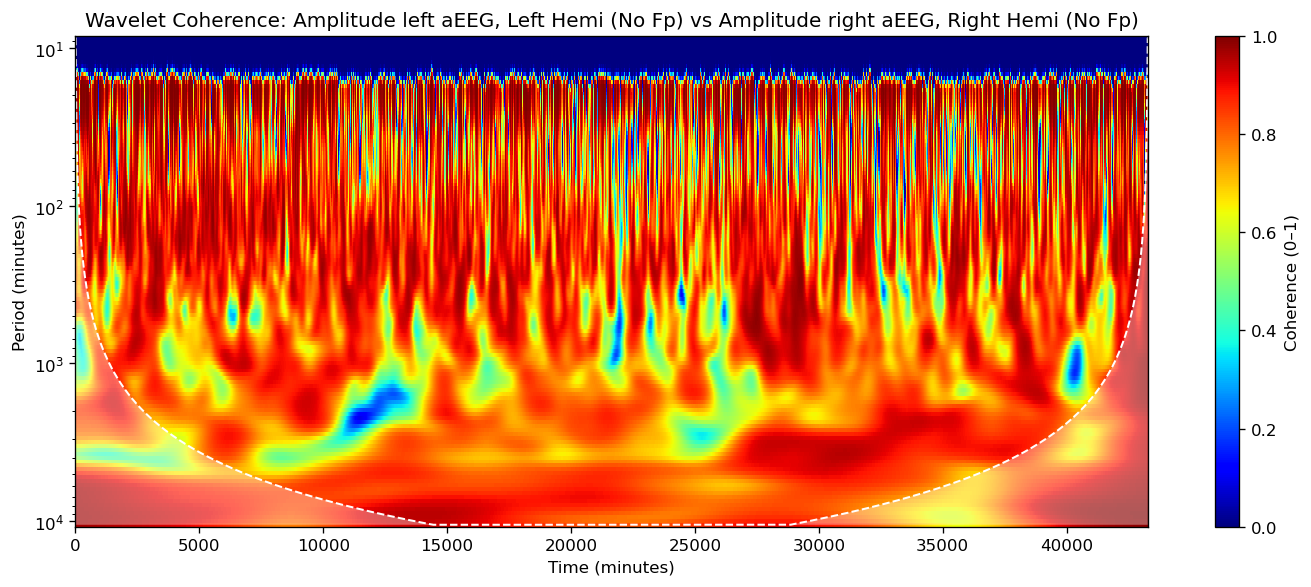

(<Figure size 1440x600 with 2 Axes>,
 <Axes: title={'center': 'Wavelet Coherence: Amplitude left aEEG, Left Hemi (No Fp) vs Amplitude right aEEG, Right Hemi (No Fp)'}, xlabel='Time (minutes)', ylabel='Period (minutes)'>,
 array([0.00000000e+00, 4.32823282e+00, 8.65646565e+00, ...,
        4.32693435e+04, 4.32736718e+04, 4.32780000e+04]),
 array([8.65646565e+00, 9.17120588e+00, 9.71655416e+00, 1.02943305e+01,
        1.09064633e+01, 1.15549953e+01, 1.22420911e+01, 1.29700437e+01,
        1.37412827e+01, 1.45583819e+01, 1.54240683e+01, 1.63412311e+01,
        1.73129313e+01, 1.83424118e+01, 1.94331083e+01, 2.05886611e+01,
        2.18129266e+01, 2.31099907e+01, 2.44841822e+01, 2.59400875e+01,
        2.74825653e+01, 2.91167637e+01, 3.08481366e+01, 3.26824622e+01,
        3.46258626e+01, 3.66848235e+01, 3.88662166e+01, 4.11773222e+01,
        4.36258531e+01, 4.62199814e+01, 4.89683645e+01, 5.18801750e+01,
        5.49651307e+01, 5.82335274e+01, 6.16962732e+01, 6.53649245e+01,
        6.92

In [109]:
root = 'C:/Users/Haiya/Downloads/OneDrive_2025-09-19/patient_data/' 
csv= 'ID2-1_496_6.4.20.csv'
df = pd.read_csv(root + csv)
df = df.drop(index=0) 
plot_wtc_from_df(df, 'Amplitude left aEEG, Left Hemi (No Fp)', 'Amplitude right aEEG, Right Hemi (No Fp)', time_col='Time', save_path='wtc_left_right.png')

### ID9 = 0 

C:\Users\Haiya\AppData\Local\Temp\ipykernel_17948\3345352024.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(root + csv)


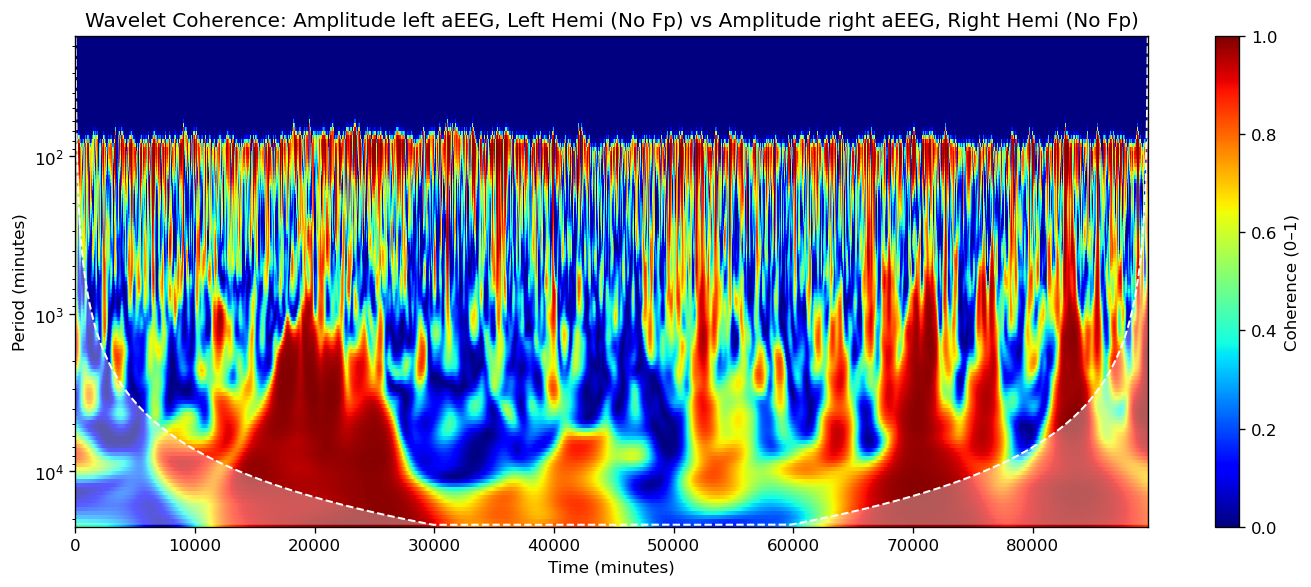

(<Figure size 1440x600 with 2 Axes>,
 <Axes: title={'center': 'Wavelet Coherence: Amplitude left aEEG, Left Hemi (No Fp) vs Amplitude right aEEG, Right Hemi (No Fp)'}, xlabel='Time (minutes)', ylabel='Period (minutes)'>,
 array([0.00000000e+00, 8.96209621e+00, 1.79241924e+01, ...,
        8.95940758e+04, 8.96030379e+04, 8.96120000e+04]),
 array([1.79241924e+01, 1.89900204e+01, 2.01192257e+01, 2.13155772e+01,
        2.25830673e+01, 2.39259264e+01, 2.53486360e+01, 2.68559443e+01,
        2.84528819e+01, 3.01447783e+01, 3.19372801e+01, 3.38363696e+01,
        3.58483848e+01, 3.79800407e+01, 4.02384515e+01, 4.26311543e+01,
        4.51661347e+01, 4.78518528e+01, 5.06972720e+01, 5.37118887e+01,
        5.69057638e+01, 6.02895566e+01, 6.38745602e+01, 6.76727392e+01,
        7.16967697e+01, 7.59600815e+01, 8.04769029e+01, 8.52623086e+01,
        9.03322693e+01, 9.57037056e+01, 1.01394544e+02, 1.07423777e+02,
        1.13811528e+02, 1.20579113e+02, 1.27749120e+02, 1.35345478e+02,
        1.43

In [122]:
root = 'C:/Users/Haiya/Downloads/OneDrive_2025-09-19/patient_data/' 
csv= 'ID9-5_719_2.5.21.csv'
df = pd.read_csv(root + csv)
df = df.drop(index=0)
plot_wtc_from_df(df, 'Amplitude left aEEG, Left Hemi (No Fp)', 'Amplitude right aEEG, Right Hemi (No Fp)', time_col='Time', save_path='wtc_left_right.png')

### ID4 = 1

C:\Users\Haiya\AppData\Local\Temp\ipykernel_17948\381549880.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(root + csv)


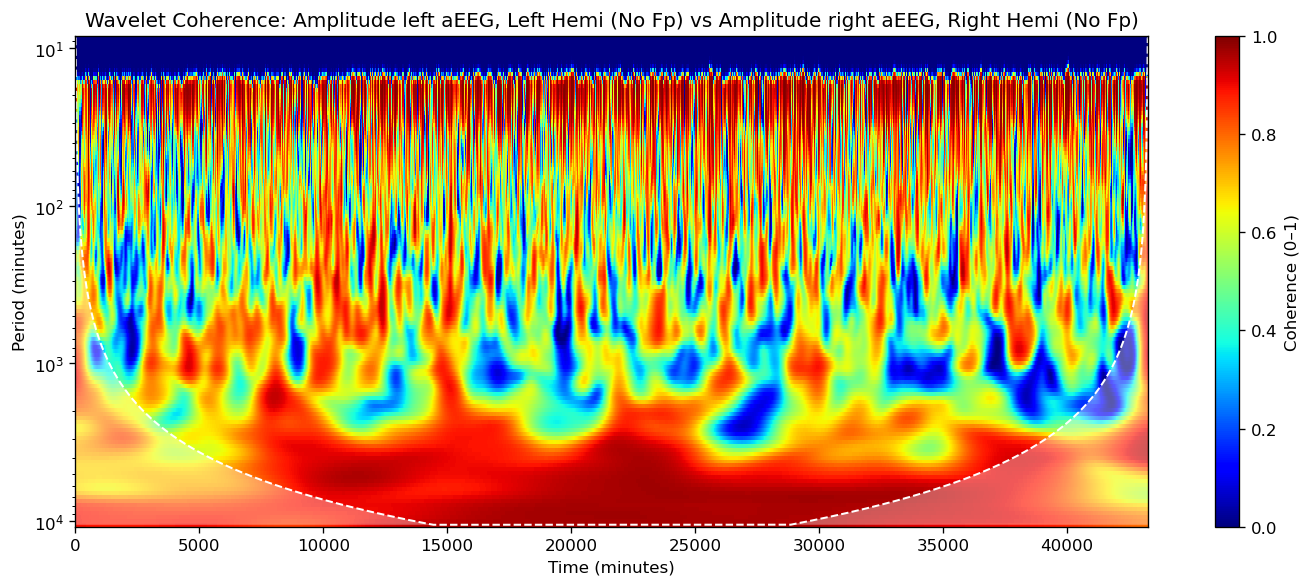

(<Figure size 1440x600 with 2 Axes>,
 <Axes: title={'center': 'Wavelet Coherence: Amplitude left aEEG, Left Hemi (No Fp) vs Amplitude right aEEG, Right Hemi (No Fp)'}, xlabel='Time (minutes)', ylabel='Period (minutes)'>,
 array([0.00000000e+00, 4.32793279e+00, 8.65586559e+00, ...,
        4.32663441e+04, 4.32706721e+04, 4.32750000e+04]),
 array([8.65586559e+00, 9.17057014e+00, 9.71588062e+00, 1.02936169e+01,
        1.09057073e+01, 1.15541944e+01, 1.22412425e+01, 1.29691447e+01,
        1.37403301e+01, 1.45573727e+01, 1.54229991e+01, 1.63400984e+01,
        1.73117312e+01, 1.83411403e+01, 1.94317612e+01, 2.05872339e+01,
        2.18114145e+01, 2.31083887e+01, 2.44824850e+01, 2.59382893e+01,
        2.74806603e+01, 2.91147454e+01, 3.08459982e+01, 3.26801967e+01,
        3.46234623e+01, 3.66822806e+01, 3.88635225e+01, 4.11744678e+01,
        4.36228290e+01, 4.62167774e+01, 4.89649700e+01, 5.18765787e+01,
        5.49613206e+01, 5.82294907e+01, 6.16919964e+01, 6.53603934e+01,
        6.92

In [126]:
root = 'C:/Users/Haiya/Downloads/OneDrive_2025-09-19/patient_data/' 
csv= 'ID4-1_794_10.1.20.csv'
df = pd.read_csv(root + csv)
df = df.drop(index=0)
plot_wtc_from_df(df, 'Amplitude left aEEG, Left Hemi (No Fp)', 'Amplitude right aEEG, Right Hemi (No Fp)', time_col='Time', save_path='wtc_left_right.png')

### ID16 = 1

C:\Users\Haiya\AppData\Local\Temp\ipykernel_17948\2632241882.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(root + csv)


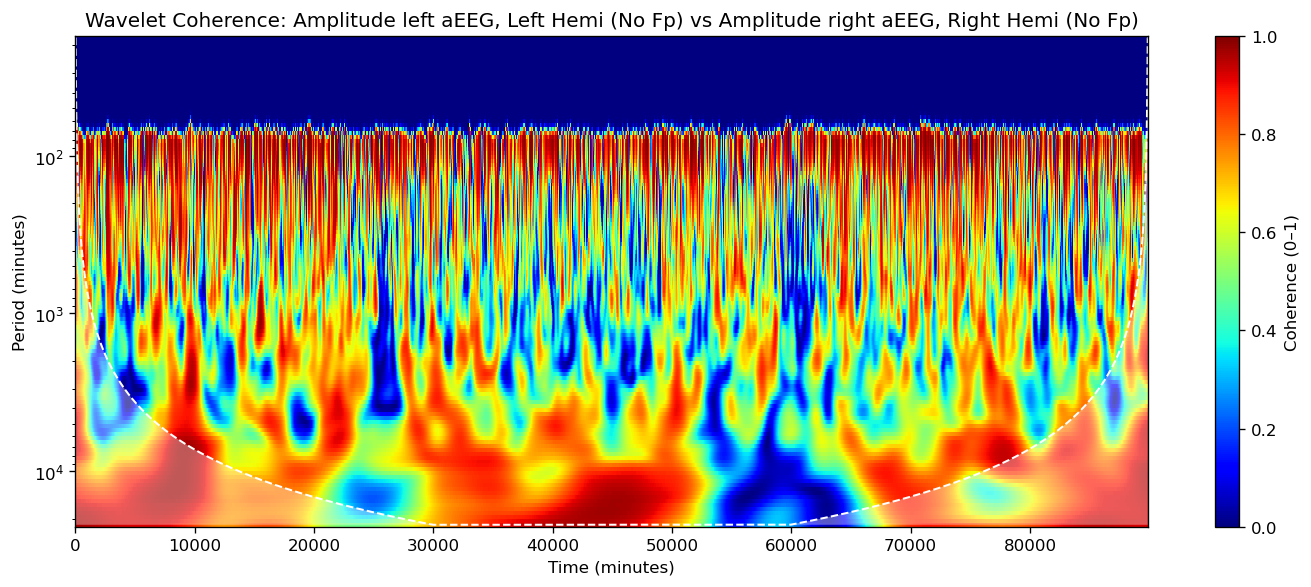

(<Figure size 1440x600 with 2 Axes>,
 <Axes: title={'center': 'Wavelet Coherence: Amplitude left aEEG, Left Hemi (No Fp) vs Amplitude right aEEG, Right Hemi (No Fp)'}, xlabel='Time (minutes)', ylabel='Period (minutes)'>,
 array([0.00000000e+00, 8.98879888e+00, 1.79775978e+01, ...,
        8.98610224e+04, 8.98700112e+04, 8.98790000e+04]),
 array([1.79775978e+01, 1.90466014e+01, 2.01791712e+01, 2.13790872e+01,
        2.26503538e+01, 2.39972140e+01, 2.54241626e+01, 2.69359619e+01,
        2.85376576e+01, 3.02345950e+01, 3.20324376e+01, 3.39371855e+01,
        3.59551955e+01, 3.80932027e+01, 4.03583424e+01, 4.27581743e+01,
        4.53007077e+01, 4.79944279e+01, 5.08483251e+01, 5.38719239e+01,
        5.70753152e+01, 6.04691900e+01, 6.40648752e+01, 6.78743709e+01,
        7.19103910e+01, 7.61864054e+01, 8.07166848e+01, 8.55163487e+01,
        9.06014154e+01, 9.59888559e+01, 1.01696650e+02, 1.07743848e+02,
        1.14150630e+02, 1.20938380e+02, 1.28129750e+02, 1.35748742e+02,
        1.43

In [131]:
root = 'C:/Users/Haiya/Downloads/OneDrive_2025-09-19/patient_data/' 
csv= 'ID16-1_590_7.15.21.csv'
df = pd.read_csv(root + csv)
df = df.drop(index=0)
plot_wtc_from_df(df, 'Amplitude left aEEG, Left Hemi (No Fp)', 'Amplitude right aEEG, Right Hemi (No Fp)', time_col='Time', save_path='wtc_left_right.png')

### ID5 = 0

C:\Users\Haiya\AppData\Local\Temp\ipykernel_17948\1816597009.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(root + csv)


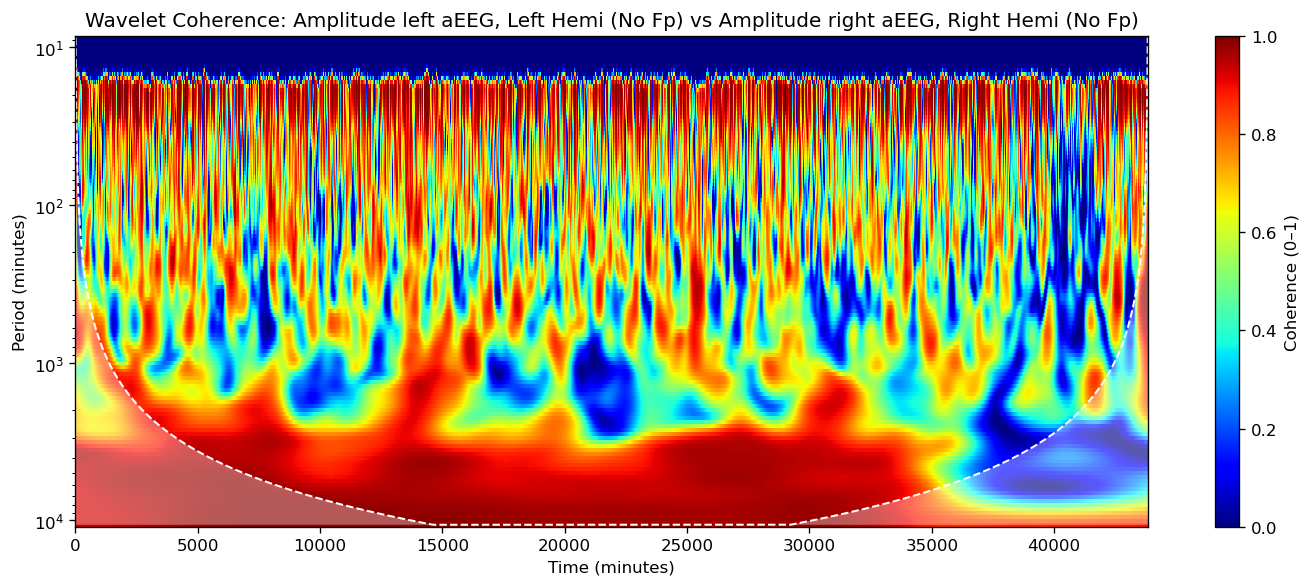

(<Figure size 1440x600 with 2 Axes>,
 <Axes: title={'center': 'Wavelet Coherence: Amplitude left aEEG, Left Hemi (No Fp) vs Amplitude right aEEG, Right Hemi (No Fp)'}, xlabel='Time (minutes)', ylabel='Period (minutes)'>,
 array([0.00000000e+00, 4.38333833e+00, 8.76667667e+00, ...,
        4.38202333e+04, 4.38246167e+04, 4.38290000e+04]),
 array([8.76667667e+00, 9.28797039e+00, 9.84026185e+00, 1.04253943e+01,
        1.10453205e+01, 1.17021094e+01, 1.23979530e+01, 1.31351737e+01,
        1.39162318e+01, 1.47437340e+01, 1.56204420e+01, 1.65492818e+01,
        1.75333533e+01, 1.85759408e+01, 1.96805237e+01, 2.08507885e+01,
        2.20906409e+01, 2.34042188e+01, 2.47959061e+01, 2.62703474e+01,
        2.78324635e+01, 2.94874679e+01, 3.12408840e+01, 3.30985637e+01,
        3.50667067e+01, 3.71518816e+01, 3.93610474e+01, 4.17015771e+01,
        4.41812819e+01, 4.68084376e+01, 4.95918122e+01, 5.25406948e+01,
        5.56649271e+01, 5.89749359e+01, 6.24817680e+01, 6.61971273e+01,
        7.01

In [135]:
root = 'C:/Users/Haiya/Downloads/OneDrive_2025-09-19/patient_data/' 
csv= 'ID5-1_609_10.5.20.csv'
df = pd.read_csv(root + csv)
df = df.drop(index=0)
plot_wtc_from_df(df, 'Amplitude left aEEG, Left Hemi (No Fp)', 'Amplitude right aEEG, Right Hemi (No Fp)', time_col='Time', save_path='wtc_left_right.png')